In [0]:
from google.colab import drive
drive.mount('/content/drive/')

In [164]:
cd "/content/drive/My Drive/ML"

/content/drive/My Drive/ML


In [0]:
from pathlib import Path

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

RANDOM_SEED = 8    # Set a random seed for reproducibility!
pd.set_option("display.max_columns", 100)

In [0]:
DATA_PATH = Path.cwd().parent / "data" / "final" / "public"

train_df = pd.read_csv(
    DATA_PATH / "/content/drive/My Drive/ML/train.csv", 
    index_col="tripid"
)
test_features_df = pd.read_csv(
    DATA_PATH / "/content/drive/My Drive/ML/test.csv", 
    index_col="tripid"
)

In [0]:
labels_df = train_df[['label']]
features_df = train_df.drop(['label'], axis=1)

In [0]:
labels_df=labels_df.replace("correct", 1)
labels_df=labels_df.replace("incorrect", 0)

In [0]:
# imputation
features_df = features_df.fillna(features_df.mean())
test_features_df = test_features_df.fillna(test_features_df.mean())

# Feature Generation

In [0]:
def haversine_array(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, (lat1, lon1, lat2, lon2))
    avg_earth_radius = 6371  # in km
    lat = lat2 - lat1
    lon = lon2 - lon1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lon * 0.5) ** 2
    h = 2 * avg_earth_radius * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lon1, lat2, lon2):
    a = haversine_array(lat1, lon1, lat1, lon2)
    b = haversine_array(lat1, lon1, lat2, lon1)
    return a + b

def bearing_array(lat1, lon1, lat2, lon2):
    avg_earth_radius = 6371  # in km
    lon_delta_rad = np.radians(lon2 - lon1)
    lat1, lon1, lat2, lon2 = map(np.radians, (lat1, lon1, lat2, lon2))
    y = np.sin(lon_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lon_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [0]:
# distance features
features_df['distance_haversine'] = haversine_array(features_df['pick_lat'], features_df['pick_lon'], features_df['drop_lat'], features_df['drop_lon'])
features_df['distance_dummy_manhattan'] = dummy_manhattan_distance(features_df['pick_lat'], features_df['pick_lon'], features_df['drop_lat'], features_df['drop_lon'])
features_df['direction'] = bearing_array(features_df['pick_lat'], features_df['pick_lon'], features_df['drop_lat'], features_df['drop_lon'])
features_df['center_lat'] = (features_df['pick_lat'] + features_df['drop_lat']) / 2
features_df['center_lon'] = (features_df['pick_lon'] + features_df['drop_lon']) / 2

test_features_df['distance_haversine'] = haversine_array(test_features_df['pick_lat'], test_features_df['pick_lon'], test_features_df['drop_lat'], test_features_df['drop_lon'])
test_features_df['distance_dummy_manhattan'] = dummy_manhattan_distance(test_features_df['pick_lat'], test_features_df['pick_lon'], test_features_df['drop_lat'], test_features_df['drop_lon'])
test_features_df['direction'] = bearing_array(test_features_df['pick_lat'], test_features_df['pick_lon'], test_features_df['drop_lat'], test_features_df['drop_lon'])
test_features_df['center_lat'] = (test_features_df['pick_lat'] + test_features_df['drop_lat']) / 2
test_features_df['center_lon'] = (test_features_df['pick_lon'] + test_features_df['drop_lon']) / 2

In [0]:
# # PCA features
# coords = np.vstack((features_df[['pick_lat', 'pick_lon']],
#                     features_df[['drop_lat', 'drop_lon']],
#                     test_features_df[['pick_lat', 'pick_lon']],
#                     test_features_df[['drop_lat', 'drop_lon']]))

# pca = PCA().fit(coords)
# features_df['pick_pca0'] = pca.transform(features_df[['pick_lat', 'pick_lon']])[:, 0]
# features_df['pick_pca1'] = pca.transform(features_df[['pick_lat', 'pick_lon']])[:, 1]
# features_df['drop_pca0'] = pca.transform(features_df[['drop_lat', 'drop_lon']])[:, 0]
# features_df['drop_pca1'] = pca.transform(features_df[['drop_lat', 'drop_lon']])[:, 1]

# test_features_df['pick_pca0'] = pca.transform(test_features_df[['pick_lat', 'pick_lon']])[:, 0]
# test_features_df['pick_pca1'] = pca.transform(test_features_df[['pick_lat', 'pick_lon']])[:, 1]
# test_features_df['drop_pca0'] = pca.transform(test_features_df[['drop_lat', 'drop_lon']])[:, 0]
# test_features_df['drop_pca1'] = pca.transform(test_features_df[['drop_lat', 'drop_lon']])[:, 1]

# features_df['pca_manhattan'] = np.abs(features_df['drop_pca1'] - features_df['pick_pca1']) + np.abs(features_df['drop_pca0'] - features_df['pick_pca0'])
# test_features_df['pca_manhattan'] = np.abs(test_features_df['drop_pca1'] - test_features_df['pick_pca1']) + np.abs(test_features_df['drop_pca0'] - test_features_df['pick_pca0'])

In [0]:
# Date & time features
features_df['pickup_time'] = pd.to_datetime(features_df.pickup_time)
features_df['drop_time'] = pd.to_datetime(features_df.drop_time)

features_df['pickup_hour'] = features_df['pickup_time'].dt.hour
features_df['pickup_minute'] = features_df['pickup_time'].dt.minute
features_df['pickup_day'] = features_df['pickup_time'].dt.day

features_df['drop_hour'] = features_df['drop_time'].dt.hour
features_df['drop_minute'] = features_df['drop_time'].dt.minute
features_df['drop_day'] = features_df['drop_time'].dt.day

features_df["effective_time"] = features_df["duration"] - features_df["meter_waiting"]

In [0]:
test_features_df['pickup_time'] = pd.to_datetime(test_features_df.pickup_time)
test_features_df['drop_time'] = pd.to_datetime(test_features_df.drop_time)

test_features_df['pickup_hour'] = test_features_df['pickup_time'].dt.hour
test_features_df['pickup_minute'] = test_features_df['pickup_time'].dt.minute
test_features_df['pickup_day'] = test_features_df['pickup_time'].dt.day

test_features_df['drop_hour'] = test_features_df['drop_time'].dt.hour
test_features_df['drop_minute'] = test_features_df['drop_time'].dt.minute
test_features_df['drop_day'] = test_features_df['drop_time'].dt.day

test_features_df["effective_time"] = test_features_df["duration"] - test_features_df["meter_waiting"]

In [0]:
# # Speed features
# features_df['avg_speed_h'] = 1000 * features_df['distance_haversine'] / features_df['duration']
# features_df['avg_speed_m'] = 1000 * features_df['distance_dummy_manhattan'] / features_df['duration']

# test_features_df['avg_speed_h'] = 1000 * test_features_df['distance_haversine'] / test_features_df['duration']
# test_features_df['avg_speed_m'] = 1000 * test_features_df['distance_dummy_manhattan'] / test_features_df['duration']

In [0]:
group_freq = '60min'

features_df['pickup_time_group'] = features_df['pickup_time'].dt.round(group_freq)
test_features_df['pickup_time_group'] = test_features_df['pickup_time'].dt.round(group_freq)

In [177]:
features_df.dtypes

additional_fare                     float64
duration                            float64
meter_waiting                       float64
meter_waiting_fare                  float64
meter_waiting_till_pickup           float64
pickup_time                  datetime64[ns]
drop_time                    datetime64[ns]
pick_lat                            float64
pick_lon                            float64
drop_lat                            float64
drop_lon                            float64
fare                                float64
distance_haversine                  float64
distance_dummy_manhattan            float64
direction                           float64
center_lat                          float64
center_lon                          float64
pickup_hour                           int64
pickup_minute                         int64
pickup_day                            int64
drop_hour                             int64
drop_minute                           int64
drop_day                        

In [178]:
features_df.shape

(17176, 25)

# Scaling

In [0]:
not_scale = ['pickup_time', 'drop_time', 'pickup_time_group']
feature_names = [f for f in features_df.columns if f not in not_scale]

In [0]:
scaler = StandardScaler()
features_df[feature_names] = scaler.fit_transform(features_df[feature_names].values)
test_features_df[feature_names] = scaler.fit_transform(test_features_df[feature_names].values)

# remove collinear variables

Text(0.5, 1.0, 'Variable Correlations')

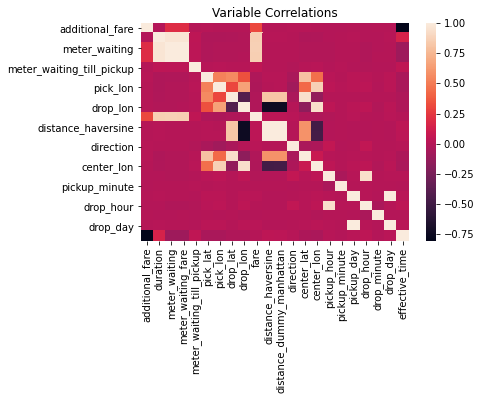

In [181]:
variable_correlations = features_df.corr()
variable_corr_heat = sns.heatmap(variable_correlations)
plt.title('Variable Correlations')

In [182]:
#Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = features_df.corr().abs()
corr_matrix.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,distance_haversine,distance_dummy_manhattan,direction,center_lat,center_lon,pickup_hour,pickup_minute,pickup_day,drop_hour,drop_minute,drop_day,effective_time
additional_fare,1.000000,0.000772,0.197605,0.199604,0.002355,0.009072,0.000616,0.004635,0.001533,0.315185,0.000431,0.000433,0.010591,0.006965,0.001273,0.005005,0.000707,0.005794,0.004665,0.000058,0.005804,0.803874
duration,0.000772,1.000000,0.969787,0.968666,0.040578,0.026925,0.025381,0.015938,0.013555,0.864975,0.012871,0.010715,0.006315,0.022239,0.020071,0.005947,0.001969,0.009452,0.005428,0.001217,0.007426,0.151021
meter_waiting,0.197605,0.969787,1.000000,0.999474,0.030447,0.016079,0.014093,0.010098,0.007876,0.869846,0.004352,0.003712,0.003920,0.013697,0.011373,0.009066,0.002244,0.005544,0.015199,0.000637,0.003626,0.094696
meter_waiting_fare,0.199604,0.968666,0.999474,1.000000,0.029908,0.014929,0.012379,0.009412,0.006780,0.864794,0.003910,0.003360,0.004098,0.012744,0.009899,0.008428,0.002129,0.004982,0.014691,0.000409,0.003032,0.097141
meter_waiting_till_pickup,0.002355,0.040578,0.030447,0.029908,1.000000,0.011329,0.016372,0.006935,0.011024,0.045454,0.003081,0.002477,0.009362,0.009522,0.014436,0.007282,0.013474,0.003943,0.009144,0.006227,0.003503,0.042213


In [0]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [184]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print(to_drop)

['meter_waiting', 'meter_waiting_fare', 'distance_dummy_manhattan', 'center_lat', 'center_lon', 'drop_hour', 'drop_day']


In [0]:
features_df = features_df.drop(columns = to_drop)
test_features_df = test_features_df.drop(columns = to_drop)